Daniel Rocha Ruiz, MSc in Data Science and Business Analytics

Sources:
- https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://vincentarelbundock.github.io/Rdatasets/datasets.html

Datasets:
- Diabetes drugs sales:
    - https://raw.githubusercontent.com/selva86/datasets/master/a10.csv
- Market arrivals:
    - https://raw.githubusercontent.com/selva86/datasets/master/MarketArrivals.csv
- XXX:
    - https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv

# Set-up
## Import packages

In [42]:
# viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# general
import numpy as np
import pandas as pd

# others
from dateutil.parser import parse
from scipy import signal
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, grangercausalitytests
from pandas.plotting import autocorrelation_plot

In [2]:
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [9]:
# dataset 2: arrivals
df = pd.read_csv('../data/MarketArrivals.csv', parse_dates=['date'], index_col='date')

df = df.loc[df.market=='MUMBAI', :]
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2004-01-01,MUMBAI,January,2004,267100,719,971,849,MS,MUMBAI
2005-01-01,MUMBAI,January,2005,275845,261,513,387,MS,MUMBAI
2006-01-01,MUMBAI,January,2006,228000,315,488,402,MS,MUMBAI
2007-01-01,MUMBAI,January,2007,205200,866,1136,997,MS,MUMBAI
2008-01-01,MUMBAI,January,2008,267550,348,550,448,MS,MUMBAI


## Plot series

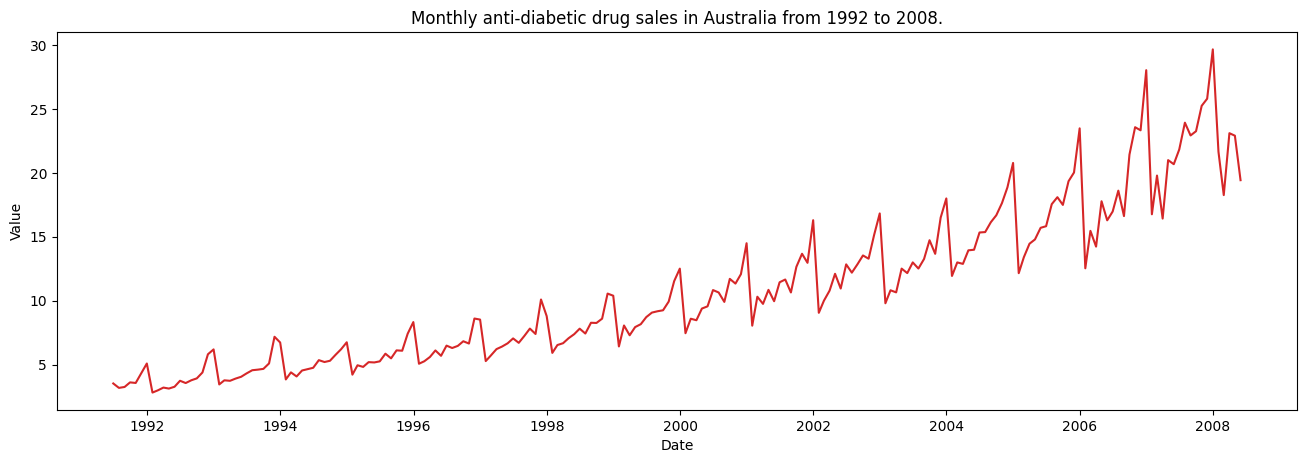

In [5]:
# dataset 1: Monthly anti-diabetic drug sales in Australia from 1992 to 2008
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.') 

## Fill Between

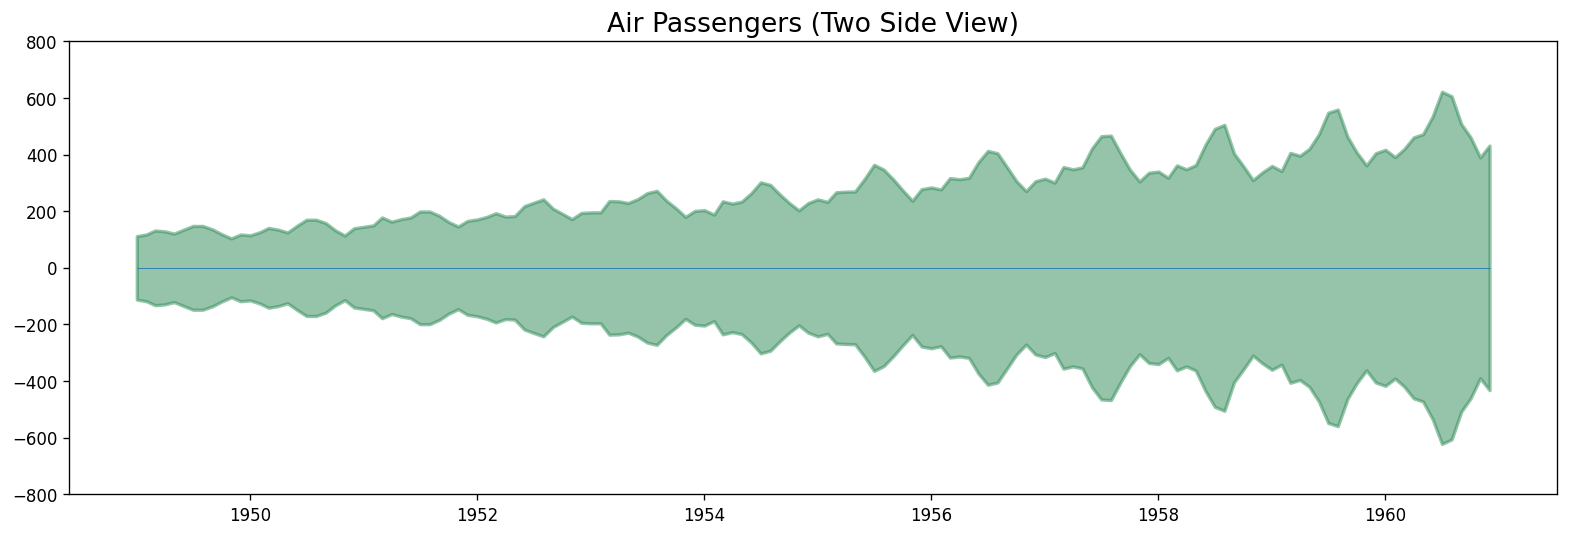

In [9]:
# import data
df = pd.read_csv('../data/AirPassengers.csv', parse_dates=['Month'])
#df = df.rename(columns={'Month': 'date', '#Passengers': 'value'})

x = df['Month'].values
y1 = df['#Passengers'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Air Passengers (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(x), xmax=np.max(x), linewidth=.5)
plt.show()

## Overlay Years

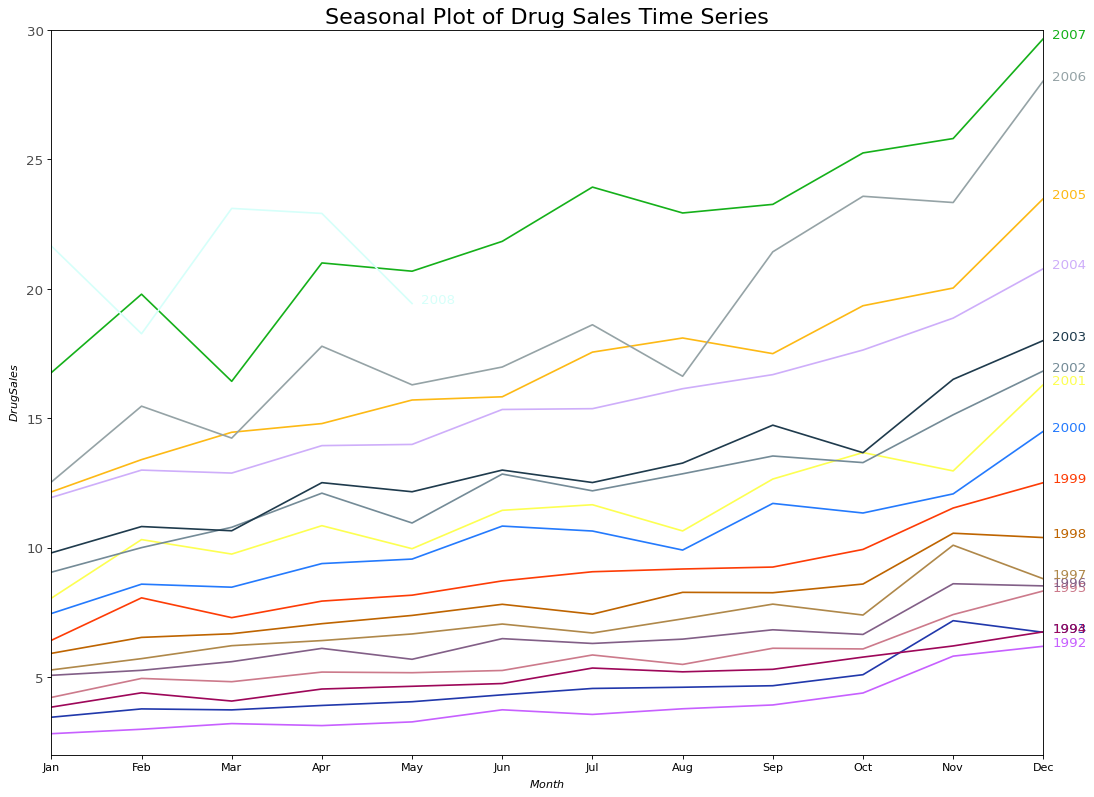

In [12]:
# Import Data
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(0, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

## Boxplots

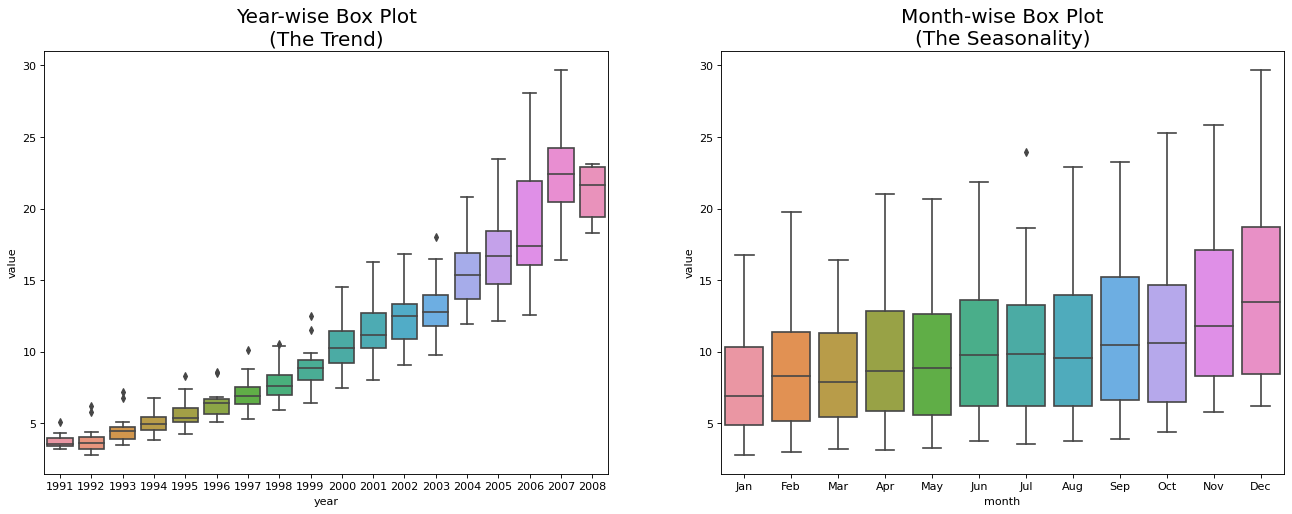

In [13]:
# Import Data
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

<AxesSubplot:title={'center':'Trend and Seasonality'}, xlabel='date'>

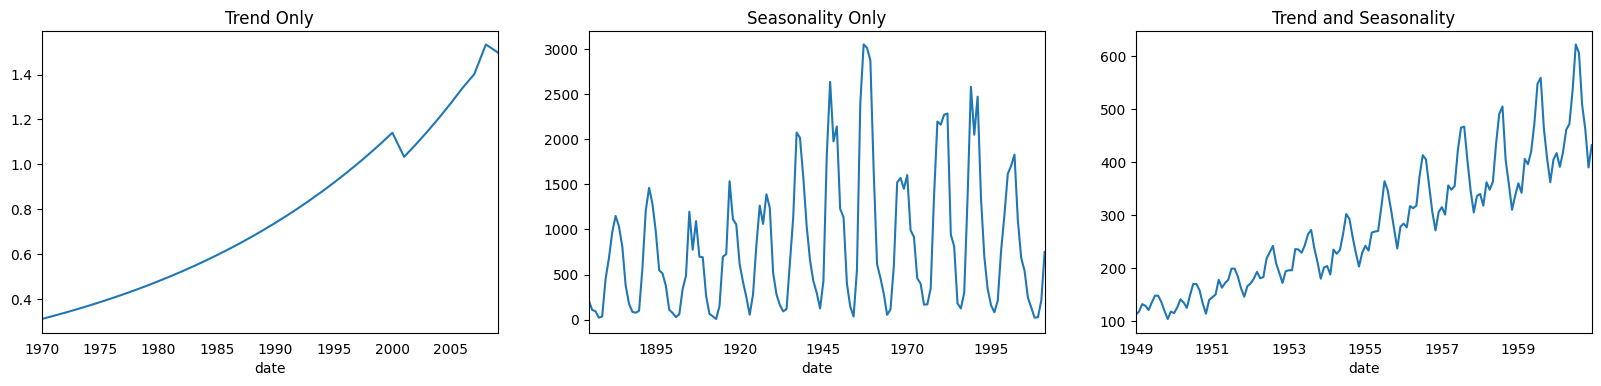

In [50]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('../data/guinearice.csv',
            parse_dates=['date'],
            index_col='date'
           ).plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('../data/sunspotarea.csv',
            parse_dates=['date'],
            index_col='date'
           ).plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('../data/AirPassengers.csv',
            parse_dates=['date'],
            index_col='date'
           ).plot(title='Trend and Seasonality', legend=False, ax=axes[2])

plt.show()

## Decomposition
### Plots

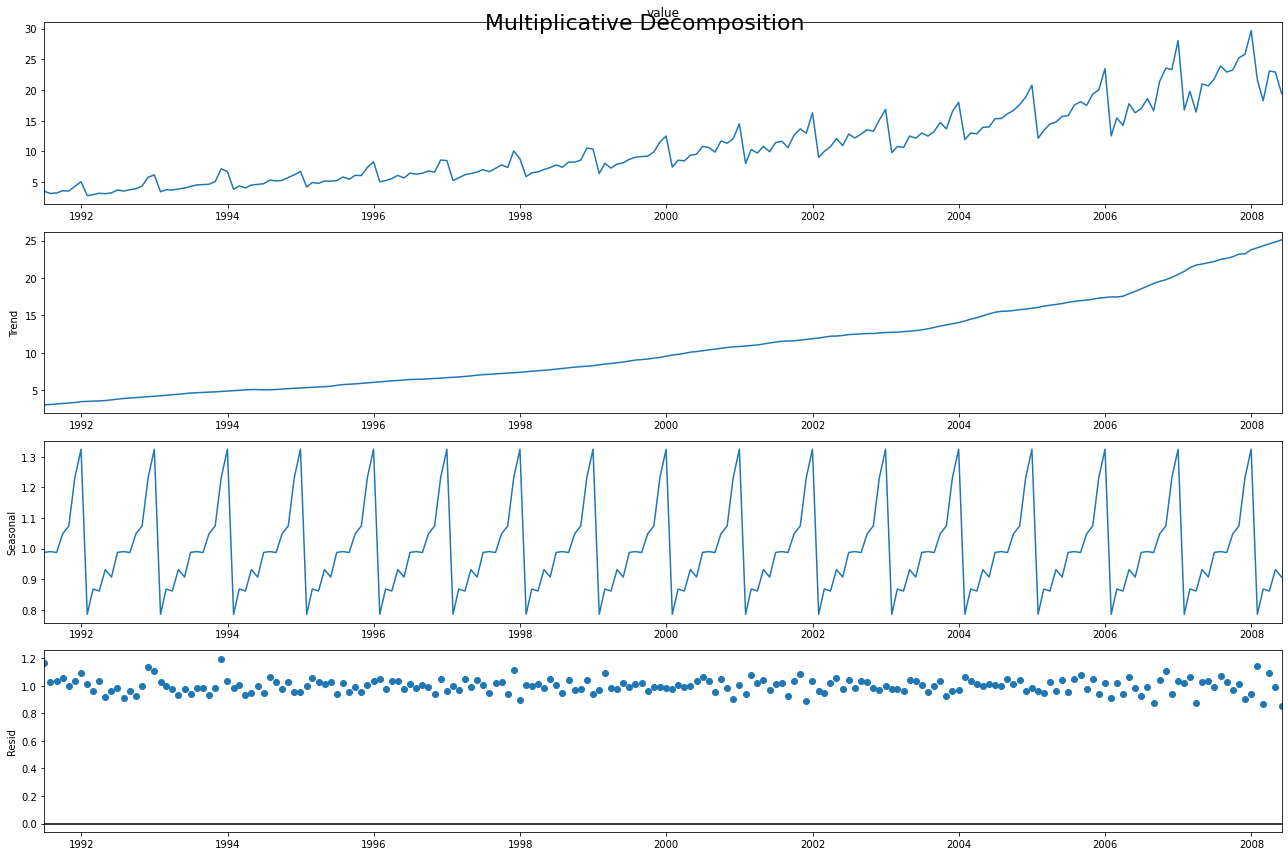

In [16]:
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
result_mul.plot().suptitle('Multiplicative Decomposition', fontsize=22)
plt.show()

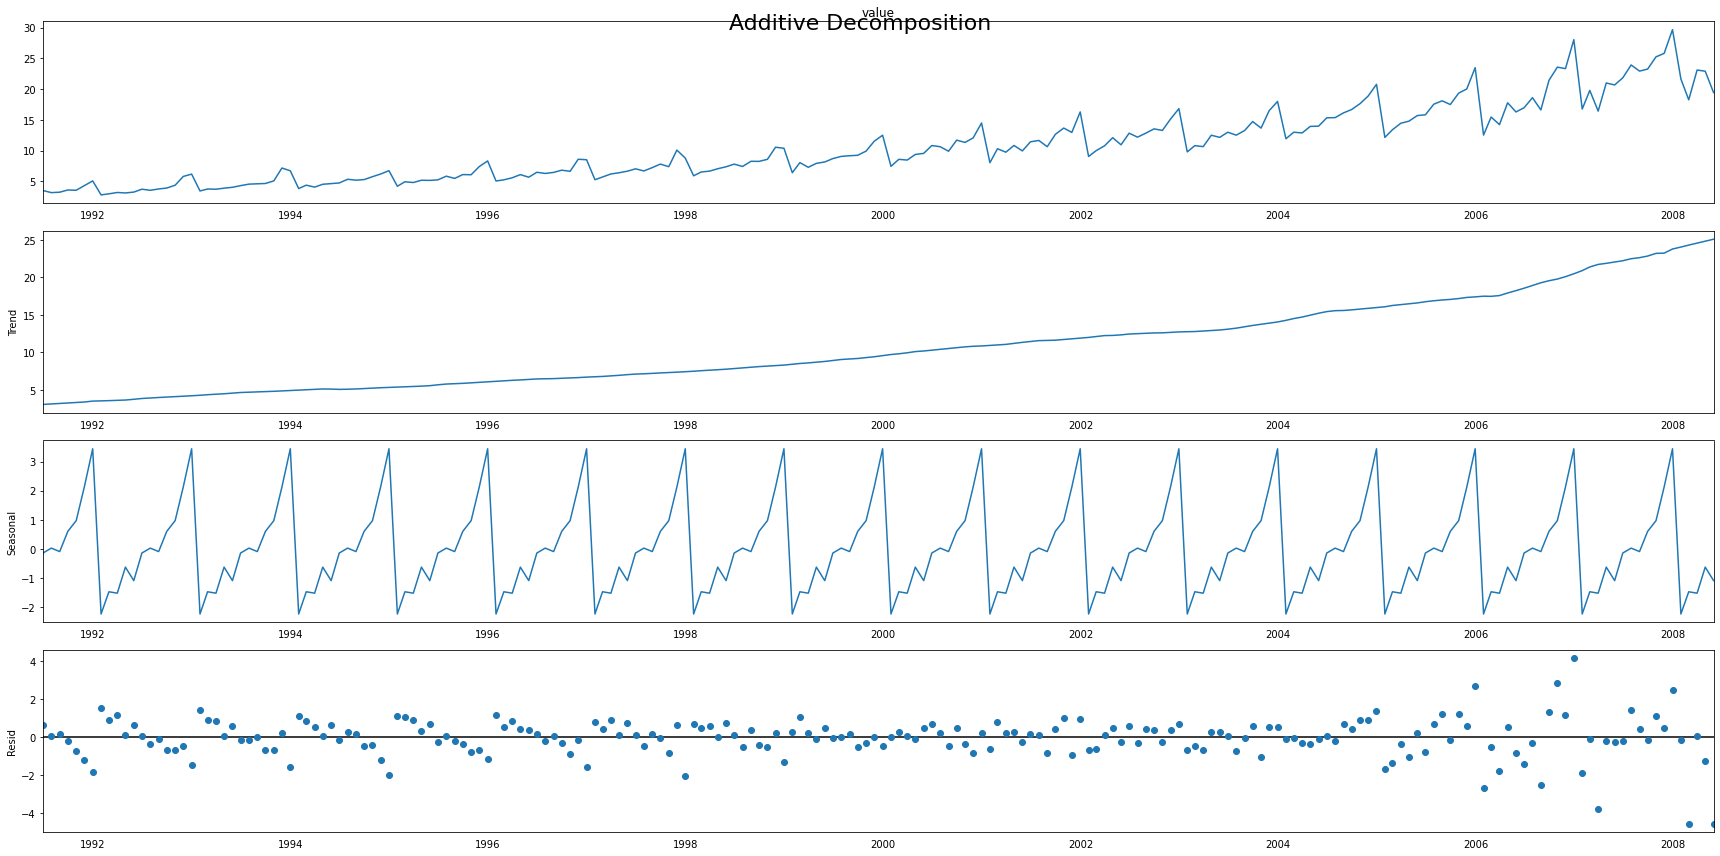

In [34]:
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (24,12)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

### Component Extraction

In [27]:
# Extract the Components
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1991-06-30,0.987845,3.060085,1.166629,3.526591
1991-07-31,0.990481,3.124765,1.027745,3.180891
1991-08-31,0.987476,3.189445,1.032615,3.252221
1991-09-30,1.048329,3.254125,1.058513,3.611003
1991-10-31,1.074527,3.318805,0.999923,3.565869


## Stationarity Tests

In [29]:
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.14518568930675
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476

KPSS Statistic: 2.013126
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## White Noise

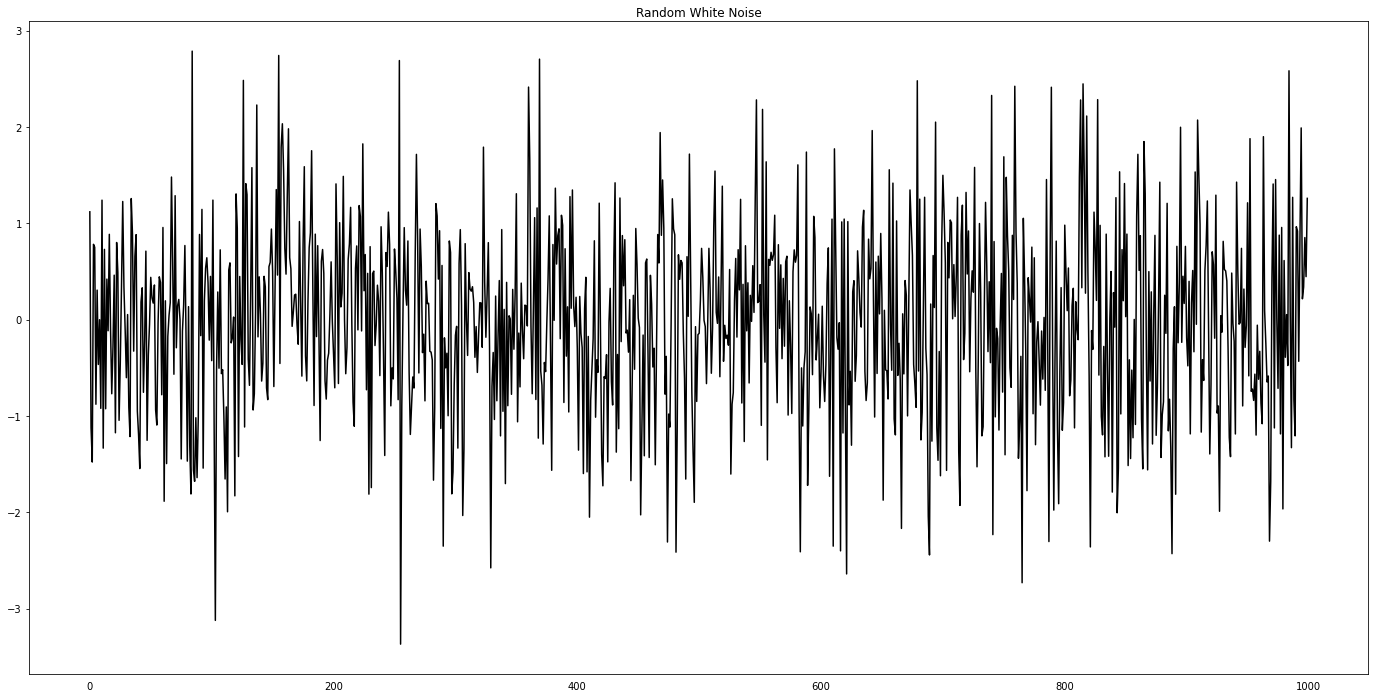

In [32]:
# generate data
randvals = np.random.randn(1000)

# plot
pd.Series(randvals).plot(title='Random White Noise', color='k')
plt.show()

## De-trending
### With Scipy

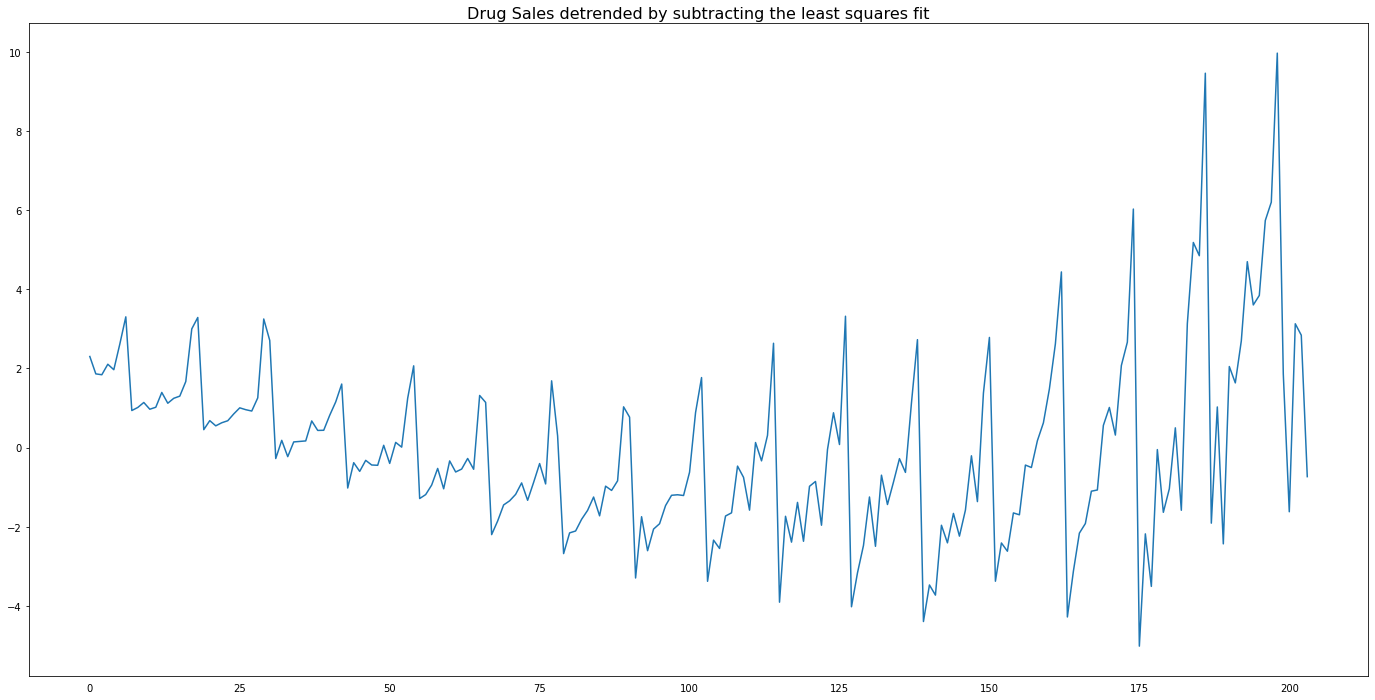

In [37]:
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# Using scipy: Subtract the line of best fit
detrended = signal.detrend(df.value.values)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)
plt.show()

### With StatsModels

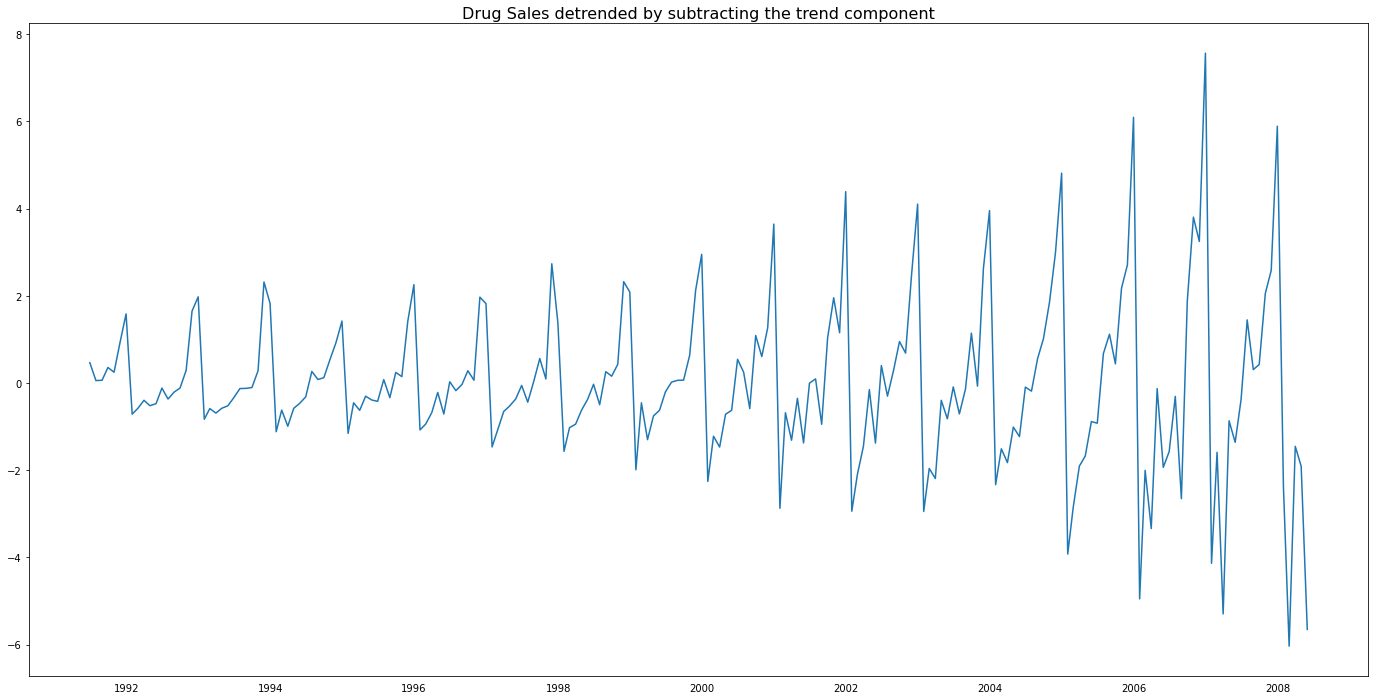

In [38]:
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# Using statmodels: Subtracting the Trend Component.
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)
plt.show()

### De-Seasonized

[]

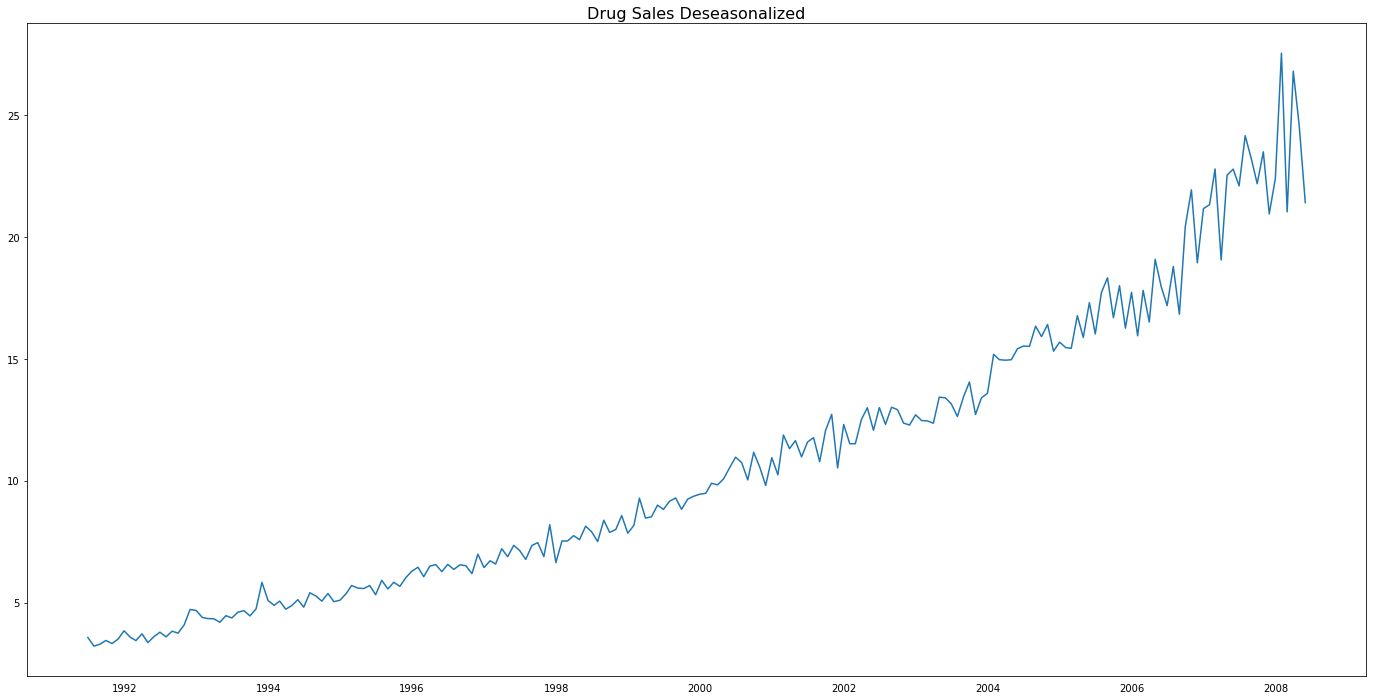

In [39]:
# Subtracting the Trend Component.
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# Time Series Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df.value.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

## ACF

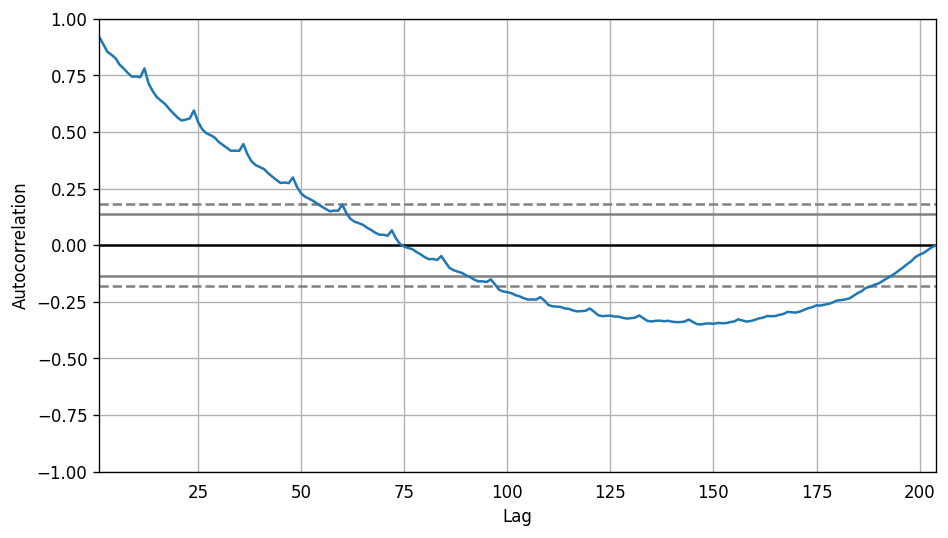

In [44]:
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())
plt.show()

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


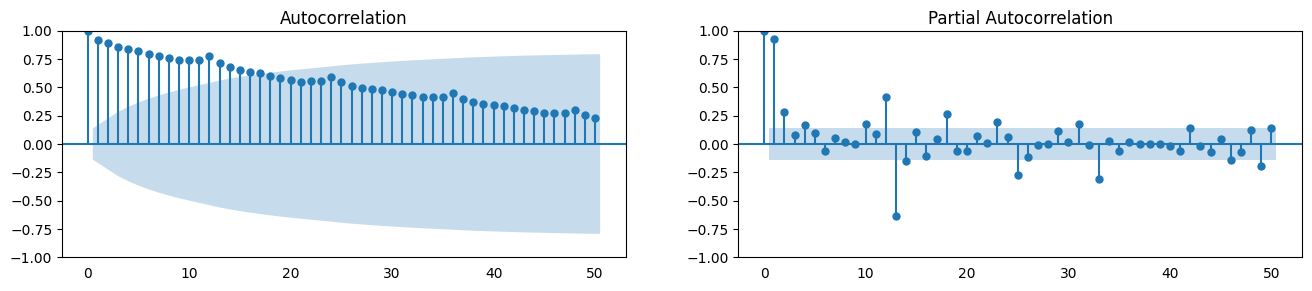

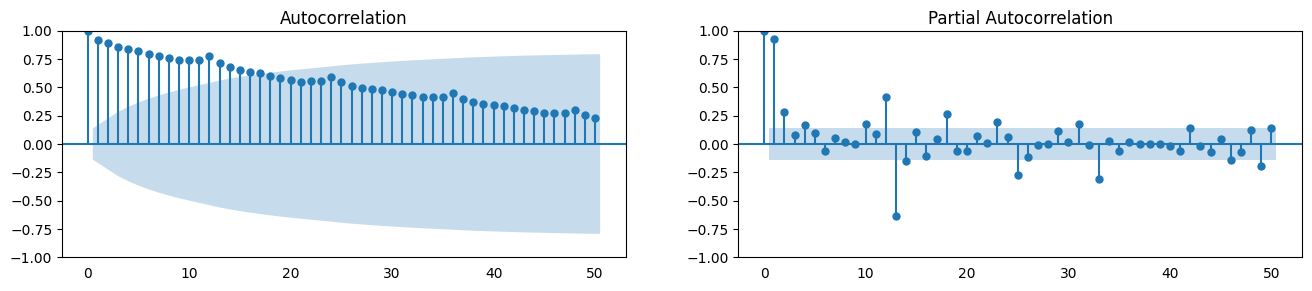

In [45]:
df = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

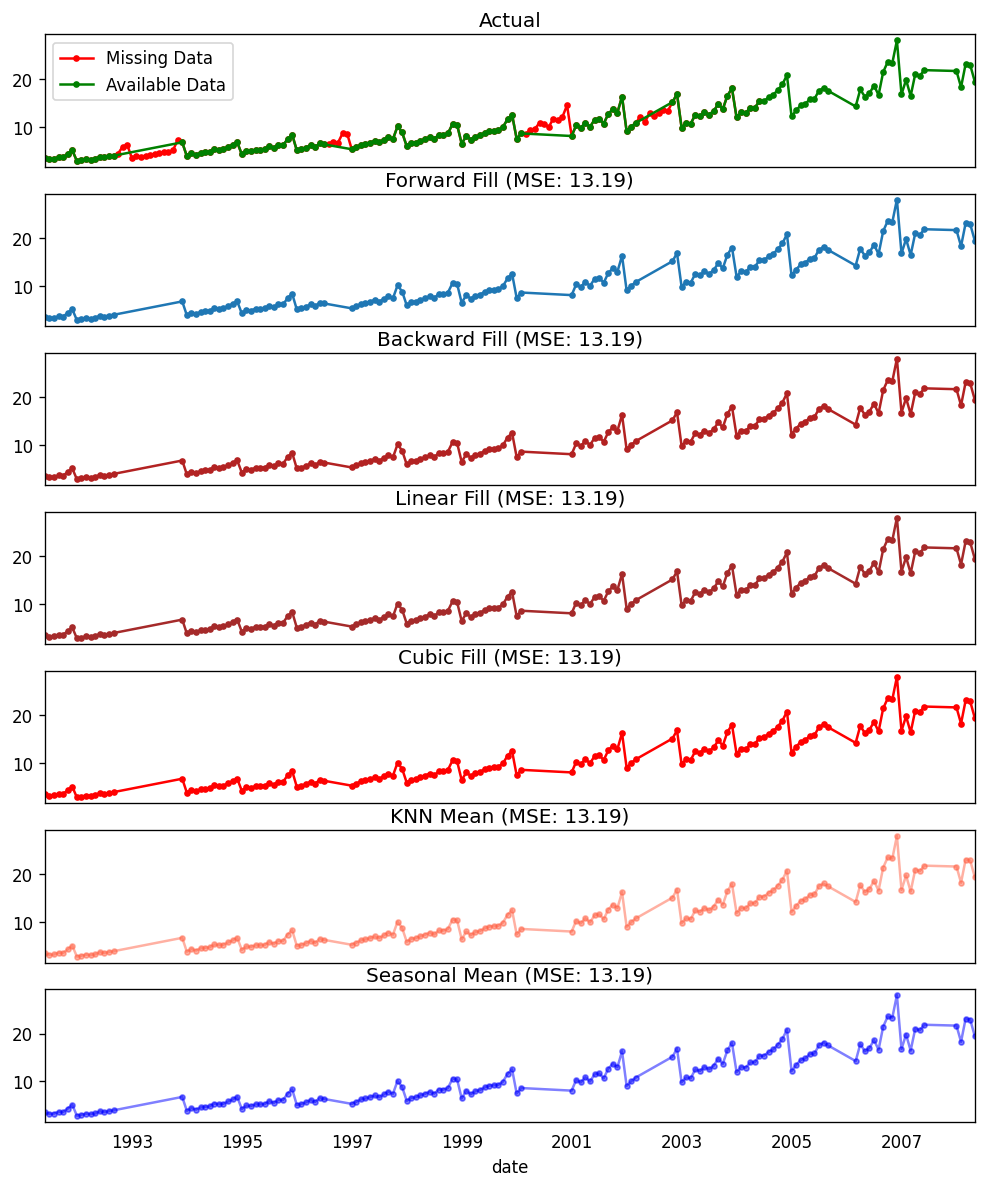

In [47]:
# # Generate dataset
df = pd.read_csv('../data/a10_missings.csv', parse_dates=['date'], index_col='date')
df_orig = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date').head(len(df))

#
fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")

plt.show()

## Entropy
### Approximate Entropy
- https://en.wikipedia.org/wiki/Approximate_entropy

In [48]:
ss = pd.read_csv('../data/sunspotarea.csv')
a10 = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')

rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(ss.value, m=2, r=0.2*np.std(ss.value)))     # 0.651
print(ApEn(a10.value, m=2, r=0.2*np.std(a10.value)))   # 0.537
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

0.6514704970333534
0.5374775224973489
0.20044343724868074
0.8443130734510151


### Sample Entropy
- https://en.wikipedia.org/wiki/Sample_entropy

In [42]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(ss.value, m=2, r=0.2*np.std(ss.value)))      # 0.78
print(SampEn(a10.value, m=2, r=0.2*np.std(a10.value)))    # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.7853311366380039
0.41887013457621214
1.7047480922384253
2.0243817644968085


## Smoothening

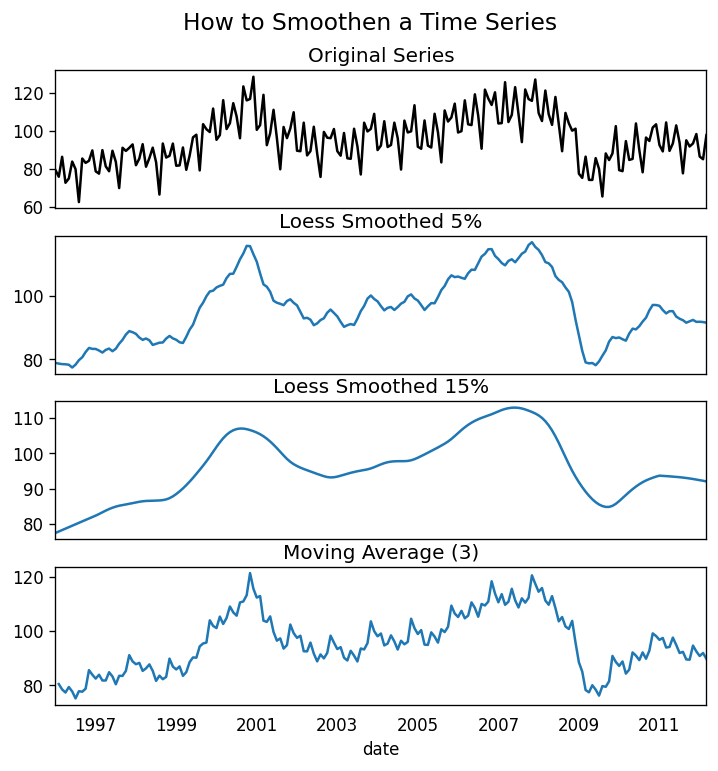

In [25]:
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# Import
df_orig = pd.read_csv('../data/elecequip.csv', parse_dates=['date'], index_col='date')

# 1. Moving Average
df_ma = df_orig.value.rolling(3, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.05)[:, 1], index=df_orig.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.15)[:, 1], index=df_orig.index, columns=['value'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df_orig['value'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

## Granger Causality Test

In [21]:
df = pd.read_csv('../data/a10.csv', parse_dates=['date'])
df['month'] = df.date.dt.month
grangercausalitytests(df[['value', 'month']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9818 , p=0.0002  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=14.1915 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7174 , p=0.0002  , df=1
parameter F test:         F=13.9818 , p=0.0002  , df_denom=200, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.4514 , p=0.0000  , df_denom=197, df_num=2
ssr based chi2 test:   chi2=29.6364 , p=0.0000  , df=2
likelihood ratio test: chi2=27.6541 , p=0.0000  , df=2
parameter F test:         F=14.4514 , p=0.0000  , df_denom=197, df_num=2


{1: ({'ssr_ftest': (13.981797483458932, 0.00024097038871825018, 200.0, 1),
   'ssr_chi2test': (14.191524445710819, 0.00016511255515735504, 1),
   'lrtest': (13.717438032628252, 0.0002124725021470115, 1),
   'params_ftest': (13.981797483458937, 0.00024097038871825018, 200.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (14.45142517403528, 1.3919856969204446e-06, 197.0, 2),
   'ssr_chi2test': (29.63642523000129, 3.6688675169465955e-07, 2),
   'lrtest': (27.654065104606616, 9.885441296340696e-07, 2),
   'params_ftest': (14.451425174035293, 1.3919856969204273e-06, 197.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}